In [8]:
using Dates, DataFrames, CSV, JSON, Plots, JuMP, HiGHS

In [2]:
#using Revise

In [1]:
using TuLiPa

[ Info: Precompiling TuLiPa [970f5c25-cd7d-4f04-b50d-7a4fe2af6639]


In [2]:
using Pkg;
Pkg.status()

Project TuLiPa v0.1.0
Status `X:\Prosjekter\2022_FoU_markedsmodell_julia\per\jules_redesign\TuLiPa\Project.toml`
⌃ [336ed68f] CSV v0.10.12
  [aaaa29a8] Clustering v0.15.7
  [a93c6f00] DataFrames v1.6.1
⌃ [87dc4568] HiGHS v1.8.0
  [a98d9a8b] Interpolations v0.15.1
  [682c06a0] JSON v0.21.4
⌃ [4076af6c] JuMP v1.18.1
⌃ [aea7be01] PrecompileTools v1.2.0
  [ade2ca70] Dates
  [9a3f8284] Random
  [10745b16] Statistics v1.9.0
  [8dfed614] Test
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [3]:
#include("./obj_elastic_demand.jl")

In [11]:
elements = [
    
    DataElement("Balance", "BaseBalance", "PowerBalance_NO2", Dict{Any, Any}("Commodity" => "Power")),    

    DataElement("Flow", "BaseFlow", "GenNucGER", Dict{Any, Any}()),

    DataElement("Arrow", "BaseArrow", "PowerBalance_NO2", Dict{Any, Any}("Balance" => "PowerBalance_NO2", "Flow" => "GenNucGER", "Conversion" => 1.0, "Direction" => "In")),
    DataElement("Cost", "CostTerm", "MCNucGER", Dict{Any, Any}("Param" => 5000.0, "WhichInstance" => "GenNucGER", "WhichConcept" => "Flow", "Direction" => "In")),
    DataElement("Capacity", "PositiveCapacity", "CapNucGER", Dict{Any, Any}("Param" => "CapNucGER", "WhichInstance" => "GenNucGER", "WhichConcept" => "Flow", "Bound" => "Upper")),
    DataElement("Param", "MWToGWhSeriesParam", "CapNucGER", Dict{Any, Any}("Level" => 5000.0, "Profile" => 1.0)),


    DataElement("RHSTerm", "BaseRHSTerm", "DemandNO2", Dict{Any, Any}("Balance" => "PowerBalance_NO2", "Param" => "DemandNO2", "Direction" => "Out")),
    DataElement("Param", "MWToGWhSeriesParam", "DemandNO2", Dict("Level" => "LevelDemandGER", "Profile" => "LevelDemandGER")),
    DataElement("TimeVector", "ConstantTimeVector", "LevelDemandGER", Dict("Value" => 1.0) ),
    
    
    DataElement("Elastic_demand_concept", "ElasticPowerDemand", "ElasticPowerDemand_1", 
                Dict{Any, Any}("Balance" => "PowerBalance_NO2"))   
        
]

power_horizon = SequentialHorizon(10, Day(1))
push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Power", (HORIZON_CONCEPT, power_horizon)))
addscenariotimeperiod!(elements, "ScenarioTimePeriod", getisoyearstart(1981), getisoyearstart(1983));

In [12]:
elements

12-element Vector{DataElement}:
 DataElement("Balance", "BaseBalance", "PowerBalance_NO2", Dict{Any, Any}("Commodity" => "Power"))
 DataElement("Flow", "BaseFlow", "GenNucGER", Dict{Any, Any}())
 DataElement("Arrow", "BaseArrow", "PowerBalance_NO2", Dict{Any, Any}("Balance" => "PowerBalance_NO2", "Flow" => "GenNucGER", "Conversion" => 1.0, "Direction" => "In"))
 DataElement("Cost", "CostTerm", "MCNucGER", Dict{Any, Any}("Param" => 5000.0, "WhichInstance" => "GenNucGER", "WhichConcept" => "Flow", "Direction" => "In"))
 DataElement("Capacity", "PositiveCapacity", "CapNucGER", Dict{Any, Any}("Param" => "CapNucGER", "WhichInstance" => "GenNucGER", "WhichConcept" => "Flow", "Bound" => "Upper"))
 DataElement("Param", "MWToGWhSeriesParam", "CapNucGER", Dict{Any, Any}("Level" => 5000.0, "Profile" => 1.0))
 DataElement("RHSTerm", "BaseRHSTerm", "DemandNO2", Dict{Any, Any}("Balance" => "PowerBalance_NO2", "Param" => "DemandNO2", "Direction" => "Out"))
 DataElement("Param", "MWToGWhSeriesParam", 

In [13]:
modelobjects = getmodelobjects(elements)

Dict{Id, Any} with 3 entries:
  Id("Elastic_demand_conce… => ElasticPowerDemand(Id("Elastic_demand_concept", …
  Id("Flow", "GenNucGER")   => BaseFlow(Id("Flow", "GenNucGER"), SequentialHori…
  Id("Balance", "PowerBala… => BaseBalance(Id("Balance", "PowerBalance_NO2"), B…

In [14]:
modelobjects[Id("Elastic_demand_concept", "ElasticPowerDemand_1")]

ElasticPowerDemand(Id("Elastic_demand_concept", "ElasticPowerDemand_1"), BaseBalance(Id("Balance", "PowerBalance_NO2"), BaseCommodity(Id("Commodity", "Power"), SequentialHorizon(SequentialPeriods([(10, Millisecond(86400000))]), nothing)), SequentialHorizon(SequentialPeriods([(10, Millisecond(86400000))]), nothing), RHSTerm[BaseRHSTerm(Id("RHSTerm", "DemandNO2"), MWToGWhSeriesParam{ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(1.0), ConstantTimeVector(1.0)), false, Dict{Any, Any}())], Dict{Any, Any}()), nothing, 0.0, 0.0, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0])

In [15]:
mymodel = JuMP.Model(HiGHS.Optimizer)
prob = JuMP_Prob(modelobjects, mymodel)

JuMP_Prob(A JuMP Model
Minimization problem with:
Variables: 110
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 10 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 10 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 10 constraints
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS
Names registered in the model: BalancePowerBalance_NO2, Elastic_demand_conceptElasticPowerDemand_1, FlowGenNucGER, Any[ElasticPowerDemand(Id("Elastic_demand_concept", "ElasticPowerDemand_1"), BaseBalance(Id("Balance", "PowerBalance_NO2"), BaseCommodity(Id("Commodity", "Power"), SequentialHorizon(SequentialPeriods([(10, Millisecond(86400000))]), nothing)), SequentialHorizon(SequentialPeriods([(10, Millisecond(86400000))]), nothing), RHSTerm[BaseRHSTerm(Id("RHSTerm", "DemandNO2"), MWToGWhSeriesParam{ConstantTimeVector, ConstantTimeVector}(ConstantTimeVector(1.0), ConstantTimeVector(1.0)), false, Dict{Any, An

In [16]:
datatime = getisoyearstart(2023)
scenariotime = getisoyearstart(1981)
prob_time = TwoTime(datatime, scenariotime)
update!(prob, prob_time)
solve!(prob)

In [17]:
objective_function(prob.model)

5000 FlowGenNucGER[1] + 5000 FlowGenNucGER[2] + 5000 FlowGenNucGER[3] + 5000 FlowGenNucGER[4] + 5000 FlowGenNucGER[5] + 5000 FlowGenNucGER[6] + 5000 FlowGenNucGER[7] + 5000 FlowGenNucGER[8] + 5000 FlowGenNucGER[9] + 5000 FlowGenNucGER[10]

In [18]:
prob.model[:Elastic_demand_conceptElasticPowerDemand_1]

10-element Vector{VariableRef}:
 Elastic_demand_conceptElasticPowerDemand_1[1]
 Elastic_demand_conceptElasticPowerDemand_1[2]
 Elastic_demand_conceptElasticPowerDemand_1[3]
 Elastic_demand_conceptElasticPowerDemand_1[4]
 Elastic_demand_conceptElasticPowerDemand_1[5]
 Elastic_demand_conceptElasticPowerDemand_1[6]
 Elastic_demand_conceptElasticPowerDemand_1[7]
 Elastic_demand_conceptElasticPowerDemand_1[8]
 Elastic_demand_conceptElasticPowerDemand_1[9]
 Elastic_demand_conceptElasticPowerDemand_1[10]

In [19]:
prob.model[:BalancePowerBalance_NO2]

10-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.EqualTo{Float64}}, ScalarShape}}:
 BalancePowerBalance_NO2[1] : -FlowGenNucGER[1] == -0.024
 BalancePowerBalance_NO2[2] : -FlowGenNucGER[2] == -0.024
 BalancePowerBalance_NO2[3] : -FlowGenNucGER[3] == -0.024
 BalancePowerBalance_NO2[4] : -FlowGenNucGER[4] == -0.024
 BalancePowerBalance_NO2[5] : -FlowGenNucGER[5] == -0.024
 BalancePowerBalance_NO2[6] : -FlowGenNucGER[6] == -0.024
 BalancePowerBalance_NO2[7] : -FlowGenNucGER[7] == -0.024
 BalancePowerBalance_NO2[8] : -FlowGenNucGER[8] == -0.024
 BalancePowerBalance_NO2[9] : -FlowGenNucGER[9] == -0.024
 BalancePowerBalance_NO2[10] : -FlowGenNucGER[10] == -0.024

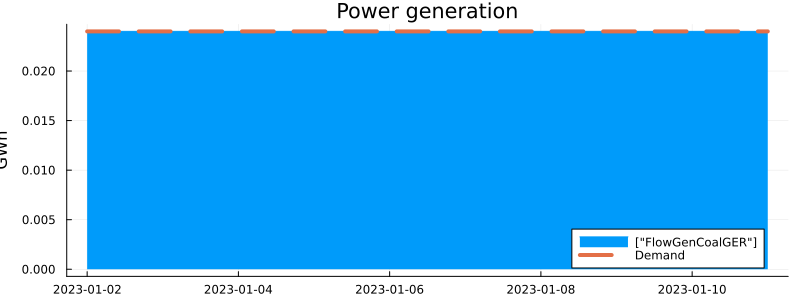

In [20]:
rhsterm = getrhsterms(modelobjects[Id("Balance", "PowerBalance_NO2")])[1]

i = []
nuc = []
demand = []

querydelta = gettimedelta(power_horizon, 1)
for t in 1:getnumperiods(power_horizon)
    querystart = getstarttime(power_horizon, t, prob_time)
    push!(i, getdatatime(querystart))
    push!(nuc, value(prob.model[:FlowGenNucGER][t]))
    push!(demand, getparamvalue(rhsterm, querystart, querydelta))
end

p = plot(areaplot(i, 
        hcat([nuc]...),
        title="Power generation", 
        ylabel = "GWh",
        label=["FlowGenCoalGER"], 
        stacked = true))
plot!(p, i, demand, lw = 4, linestyle = :dash, label = "Demand", size=(800,300))

In [21]:
prob.model[:Elastic_demand_conceptElasticPowerDemand_1]

10-element Vector{VariableRef}:
 Elastic_demand_conceptElasticPowerDemand_1[1]
 Elastic_demand_conceptElasticPowerDemand_1[2]
 Elastic_demand_conceptElasticPowerDemand_1[3]
 Elastic_demand_conceptElasticPowerDemand_1[4]
 Elastic_demand_conceptElasticPowerDemand_1[5]
 Elastic_demand_conceptElasticPowerDemand_1[6]
 Elastic_demand_conceptElasticPowerDemand_1[7]
 Elastic_demand_conceptElasticPowerDemand_1[8]
 Elastic_demand_conceptElasticPowerDemand_1[9]
 Elastic_demand_conceptElasticPowerDemand_1[10]